# 1. Tổng quan về FPT và CMG

### 1. **FPT Corporation (FPT)**
   - **Ngành nghề**: Công nghệ thông tin và Viễn thông.
   - **Mô tả**: FPT là tập đoàn công nghệ hàng đầu tại Việt Nam, hoạt động trong nhiều lĩnh vực như phần mềm, dịch vụ IT, viễn thông, và giáo dục. FPT có mạng lưới khách hàng rộng lớn trong nước và quốc tế.

### 2. **CMC Corporation (CMG)**
   - **Ngành nghề**: Công nghệ thông tin và Viễn thông.
   - **Mô tả**: CMC là một trong những tập đoàn công nghệ lớn tại Việt Nam, chuyên cung cấp các giải pháp về phần mềm, hạ tầng IT, và an ninh mạng. CMC cạnh tranh trực tiếp với FPT trong một số lĩnh vực.



In [7]:
!pip install pandas numpy scipy matplotlib


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats

# Đọc và xử lý dữ liệu
def process_stock_data(df):
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    return df

# Tính toán các metrics
def calculate_metrics(df):
    df['daily_returns'] = df['close'].pct_change()
    df['volatility'] = df['daily_returns'].rolling(window=20).std() * np.sqrt(252)
    df['MA20'] = df['close'].rolling(window=20).mean()
    df['MA50'] = df['close'].rolling(window=50).mean()
    return df

# Load dữ liệu
fpt_df = process_stock_data(pd.read_csv('../data/raw/1_FPT_stock_data.csv'))
cmg_df = process_stock_data(pd.read_csv('../data/raw/2_CMG_stock_data.csv'))

# Tính toán metrics cho cả hai cổ phiếu
fpt_df = calculate_metrics(fpt_df)
cmg_df = calculate_metrics(cmg_df)

# Tính correlation
correlation = fpt_df['close'].corr(cmg_df['close'])

# Tính beta của CMG so với FPT
fpt_returns = fpt_df['daily_returns'].dropna()
cmg_returns = cmg_df['daily_returns'].dropna()
beta = np.cov(cmg_returns, fpt_returns)[0,1] / np.var(fpt_returns)

# Tính toán thống kê cơ bản
def calculate_statistics(df, name):
    stats_dict = {
        'Mean Price': df['close'].mean(), # Giá trung bình
        'Std Dev': df['close'].std(), # Độ lệch chuẩn: Độ biến động (Std Dev). Độ biến động giúp đo lường mức độ giá cổ phiếu dao động lên xuống nhiều hay ít.
        'Min Price': df['close'].min(), # Giá thấp nhất
        'Max Price': df['close'].max(), # Giá cao nhất
        'Avg Volume': df['volume'].mean(), # Thể tích trung bình: Thể tích giao dịch trung bình trong một ngày. Thể tích giao dịch lớn thường cho thấy sự hoạt động và sự quan tâm của thị trường đối với cổ phiếu.
        'Avg Daily Return': df['daily_returns'].mean() * 100, # Tỷ suất sinh lời trung bình ngày
        'Volatility': df['daily_returns'].std() * np.sqrt(252) * 100 # Độ biến động hàng năm (Volatility)
    }
    return pd.Series(stats_dict, name=name)

fpt_stats = calculate_statistics(fpt_df, 'FPT')
cmg_stats = calculate_statistics(cmg_df, 'CMG')

# In kết quả phân tích
print("\nCorrelation between FPT and CMG:", correlation)
print("\nBeta of CMG relative to FPT:", beta)
print("\nStatistical Analysis:")
print(pd.concat([fpt_stats, cmg_stats], axis=1))

# Tính toán spread
common_dates = fpt_df.index.intersection(cmg_df.index)
price_spread = fpt_df.loc[common_dates, 'close'] - cmg_df.loc[common_dates, 'close']
spread_zscore = stats.zscore(price_spread)

# Tính % thời gian spread vượt quá 2 std
spread_threshold = np.abs(spread_zscore) > 2
spread_anomaly_pct = (spread_threshold.sum() / len(spread_zscore)) * 100

print(f"\nSpread Analysis:")
print(f"Mean Spread: {price_spread.mean():.2f}")
print(f"Spread Std Dev: {price_spread.std():.2f}")
print(f"% time spread > 2 std: {spread_anomaly_pct:.2f}%")


Correlation between FPT and CMG: 0.9042464877899152

Beta of CMG relative to FPT: 0.6723895932067658

Statistical Analysis:
                           FPT            CMG
Mean Price        8.911247e+04   42353.355556
Std Dev           2.701464e+04   10068.080063
Min Price         5.686000e+04   30760.000000
Max Price         1.417000e+05   70600.000000
Avg Volume        2.623196e+06  469893.951111
Avg Daily Return  1.941361e-01       0.124691
Volatility        2.232923e+01      33.736156

Spread Analysis:
Mean Spread: 46759.11
Spread Std Dev: 18419.36
% time spread > 2 std: 3.33%


## 1.2 Nhận xét

Từ các số liệu thống kê, tôi sẽ phân tích chi tiết từng khía cạnh:

1. Phân tích Correlation và Beta:

- Correlation = 0.904 (90.4%): 
  * Tương quan rất mạnh giữa FPT và CMG
  * Điều này phản ánh hai công ty cùng ngành công nghệ, chịu ảnh hưởng từ các yếu tố vĩ mô giống nhau
  * Tương quan cao tạo cơ sở cho chiến lược pair trading

- Beta = 0.672:
  * Beta < 1 cho thấy CMG ít biến động hơn FPT khi thị trường biến động
  * CMG có thể được coi là cổ phiếu phòng thủ hơn so với FPT
  * Mỗi khi FPT thay đổi 1%, CMG thay đổi khoảng 0.67%

2. So sánh Thống kê:

- Giá trị trung bình:
  * FPT: 89,112 đồng
  * CMG: 42,353 đồng
  * FPT có giá cao hơn gấp đôi CMG, phản ánh quy mô và vị thế dẫn đầu

- Độ biến động (Std Dev):
  * FPT: 27,014 đồng
  * CMG: 10,068 đồng
  * Độ lệch chuẩn của FPT cao hơn do giá cao hơn

- Thanh khoản (Avg Volume):
  * FPT: 2.62 triệu cp/ngày
  * CMG: 469 nghìn cp/ngày
  * FPT có thanh khoản cao hơn 5.5 lần, thuận lợi cho giao dịch lớn

- Tỷ suất sinh lời trung bình ngày:
  * FPT: 0.194%
  * CMG: 0.125%
  * FPT có tỷ suất sinh lời cao hơn

- Volatility (Độ biến động):
  * FPT: 22.33%
  * CMG: 33.74%
  * CMG có độ biến động cao hơn 1.5 lần, rủi ro cao hơn

3. Phân tích Spread:

- Mean Spread = 46,759 đồng:
  * Đây là khoảng cách trung bình giữa giá FPT và CMG
  * Dùng làm mốc tham chiếu cho chiến lược pair trading

- Spread Std Dev = 18,419 đồng:
  * Độ lệch chuẩn của spread khá lớn
  * Tạo cơ hội cho giao dịch khi có biến động mạnh

- % time spread > 2 std = 3.33%:
  * Chỉ có 3.33% thời gian spread vượt quá 2 độ lệch chuẩn
  * Đây là tần suất hợp lý cho chiến lược pair trading
  * Không quá thường xuyên để tránh false signals
  * Đủ để tạo cơ hội giao dịch có ý nghĩa

4. Đề xuất Chiến lược:

a) Pair Trading:
- Entry: Khi spread vượt ±2 std (khoảng 83,597 đồng)
- Exit: Khi spread về mean (46,759 đồng)
- Stop loss: 3 std (≈ 101,016 đồng)

b) Phân bổ vốn:
- Do FPT có thanh khoản tốt hơn, nên ưu tiên FPT là trụ cột chính
- CMG dùng làm công cụ hedge và tận dụng biến động

c) Quản trị rủi ro:
- Set position size dựa trên volatility của từng mã
- Cân nhắc beta khi xác định tỷ lệ hedge
- Theo dõi correlation để điều chỉnh chiến lược kịp thời

## 1.3 Cùng phân tích để hiểu hơn:



### 1. Tương quan (Correlation) và Beta

**Tương quan (Correlation) là gì?**
- Hãy tưởng tượng FPT và CMG như hai người bạn cùng đi học. Nếu một bạn vui thì bạn kia cũng thường vui theo, hoặc nếu một bạn buồn thì bạn kia cũng buồn theo. Đó là khi hai bạn có **tương quan cao**.
- Trong trường hợp của FPT và CMG, chỉ số tương quan là **0.904** (tức là 90.4%), nghĩa là **khi giá cổ phiếu FPT tăng, giá CMG cũng tăng theo khá nhiều** và ngược lại. Điều này là vì cả hai công ty đều thuộc ngành công nghệ và bị ảnh hưởng bởi những thay đổi giống nhau trên thị trường.

**Beta là gì?**
- Beta giúp chúng ta biết cổ phiếu thay đổi như thế nào so với thị trường chung. Nếu Beta là **1**, thì khi thị trường tăng 1%, cổ phiếu đó cũng tăng 1%.
- CMG có Beta là **0.672**. Điều này nghĩa là nếu FPT (thị trường) tăng 1%, CMG chỉ tăng **0.67%** thôi. Nghĩa là **CMG ít nhạy cảm hơn với biến động thị trường**, giống như một người đi bộ chậm hơn khi bạn đi nhanh.

---

### 2. So sánh các chỉ số cơ bản

**Giá trung bình của cổ phiếu**
- FPT có giá trung bình khoảng **89,112 đồng** (gần 90,000 đồng), trong khi CMG chỉ có **42,353 đồng**. Điều này giống như ta có một món đồ chơi rất xịn và một món bình thường, món xịn tất nhiên có giá cao hơn.

**Độ biến động (Std Dev)**
- Độ biến động giúp đo lường mức độ giá cổ phiếu dao động lên xuống nhiều hay ít.
- FPT có độ biến động **27,014 đồng**, cao hơn CMG (**10,068 đồng**). Điều này có nghĩa là **FPT dao động mạnh hơn CMG**, giống như có một con sóng lớn so với sóng nhỏ.

**Thanh khoản (Volume)**
- Đây là số lượng cổ phiếu được mua bán mỗi ngày. FPT có khoảng **2.62 triệu cổ phiếu/ngày** trong khi CMG chỉ có **469 nghìn cổ phiếu/ngày**. Nghĩa là FPT được giao dịch nhiều hơn rất nhiều, giống như việc cửa hàng bán được nhiều hàng hơn mỗi ngày.

**Tỷ suất sinh lời trung bình ngày**
- FPT có tỷ suất sinh lời **0.194%** mỗi ngày, còn CMG là **0.125%**. Điều này có nghĩa là **FPT mang lại lợi nhuận cao hơn** cho nhà đầu tư mỗi ngày, giống như bạn kiếm được nhiều tiền hơn khi bán hàng.

**Độ biến động hàng năm (Volatility)**
- FPT có độ biến động hàng năm là **22.33%**, còn CMG là **33.74%**. Nghĩa là **CMG có nhiều rủi ro hơn** do biến động mạnh hơn. Nếu ta đầu tư vào CMG, có thể sẽ "cảm thấy như đang đi tàu lượn siêu tốc" hơn so với FPT.

---

### 3. Phân tích Spread (Chênh lệch giá)

**Spread là gì?**
- Spread là sự khác biệt giữa giá của FPT và CMG. Nếu FPT giống như một bạn cao hơn CMG, thì spread là khoảng cách chiều cao giữa hai bạn.
- Spread trung bình là **46,759 đồng**. Điều này nghĩa là **trung bình giá FPT luôn cao hơn giá CMG khoảng 46,759 đồng**.

**Phân tích Spread để giao dịch**
- Khi spread vượt quá **2 độ lệch chuẩn (std)**, tức là khi chênh lệch giá quá lớn, có thể là **một cơ hội tốt để mua vào hoặc bán ra** vì sau đó giá có thể trở lại bình thường.

**Phần trăm thời gian spread > 2 std**
- Chỉ có **3.33% thời gian** mà spread vượt quá mức này. Giống như khi hai bạn (FPT và CMG) thường đi gần nhau, nhưng chỉ thỉnh thoảng một bạn đi nhanh hơn rất xa so với bạn kia.

---

### 4. Đề xuất Chiến lược Đơn giản

**a) Pair Trading (Giao dịch cặp)**
- **Pair trading** là chiến lược dựa trên sự chênh lệch giá của hai cổ phiếu có tương quan cao. Khi khoảng cách giữa hai bạn (FPT và CMG) quá lớn, ta có thể **đợi nó thu hẹp lại** để kiếm lời.
- Nếu spread lớn hơn **83,597 đồng** (khoảng ±2 std), có thể **mua CMG và bán FPT**, sau đó chờ giá quay về mức trung bình **46,759 đồng** để chốt lời.

**b) Phân bổ vốn**
- Vì FPT dễ mua bán hơn (thanh khoản cao hơn), chúng ta có thể **dành nhiều tiền hơn cho FPT** và dùng CMG để giảm rủi ro.

**c) Quản trị rủi ro**
- Đặt **giới hạn lỗ** khi spread lên tới **101,016 đồng** (tức là ±3 std). Nếu quá mức này thì có thể chiến lược của chúng ta không đúng và nên dừng lại để tránh lỗ.



# 2. Phân tích sâu hơn về mối quan hệ pair trading giữa FPT và CMG, tập trung vào spread, correlation theo thời gian và tác động của COVID-19.

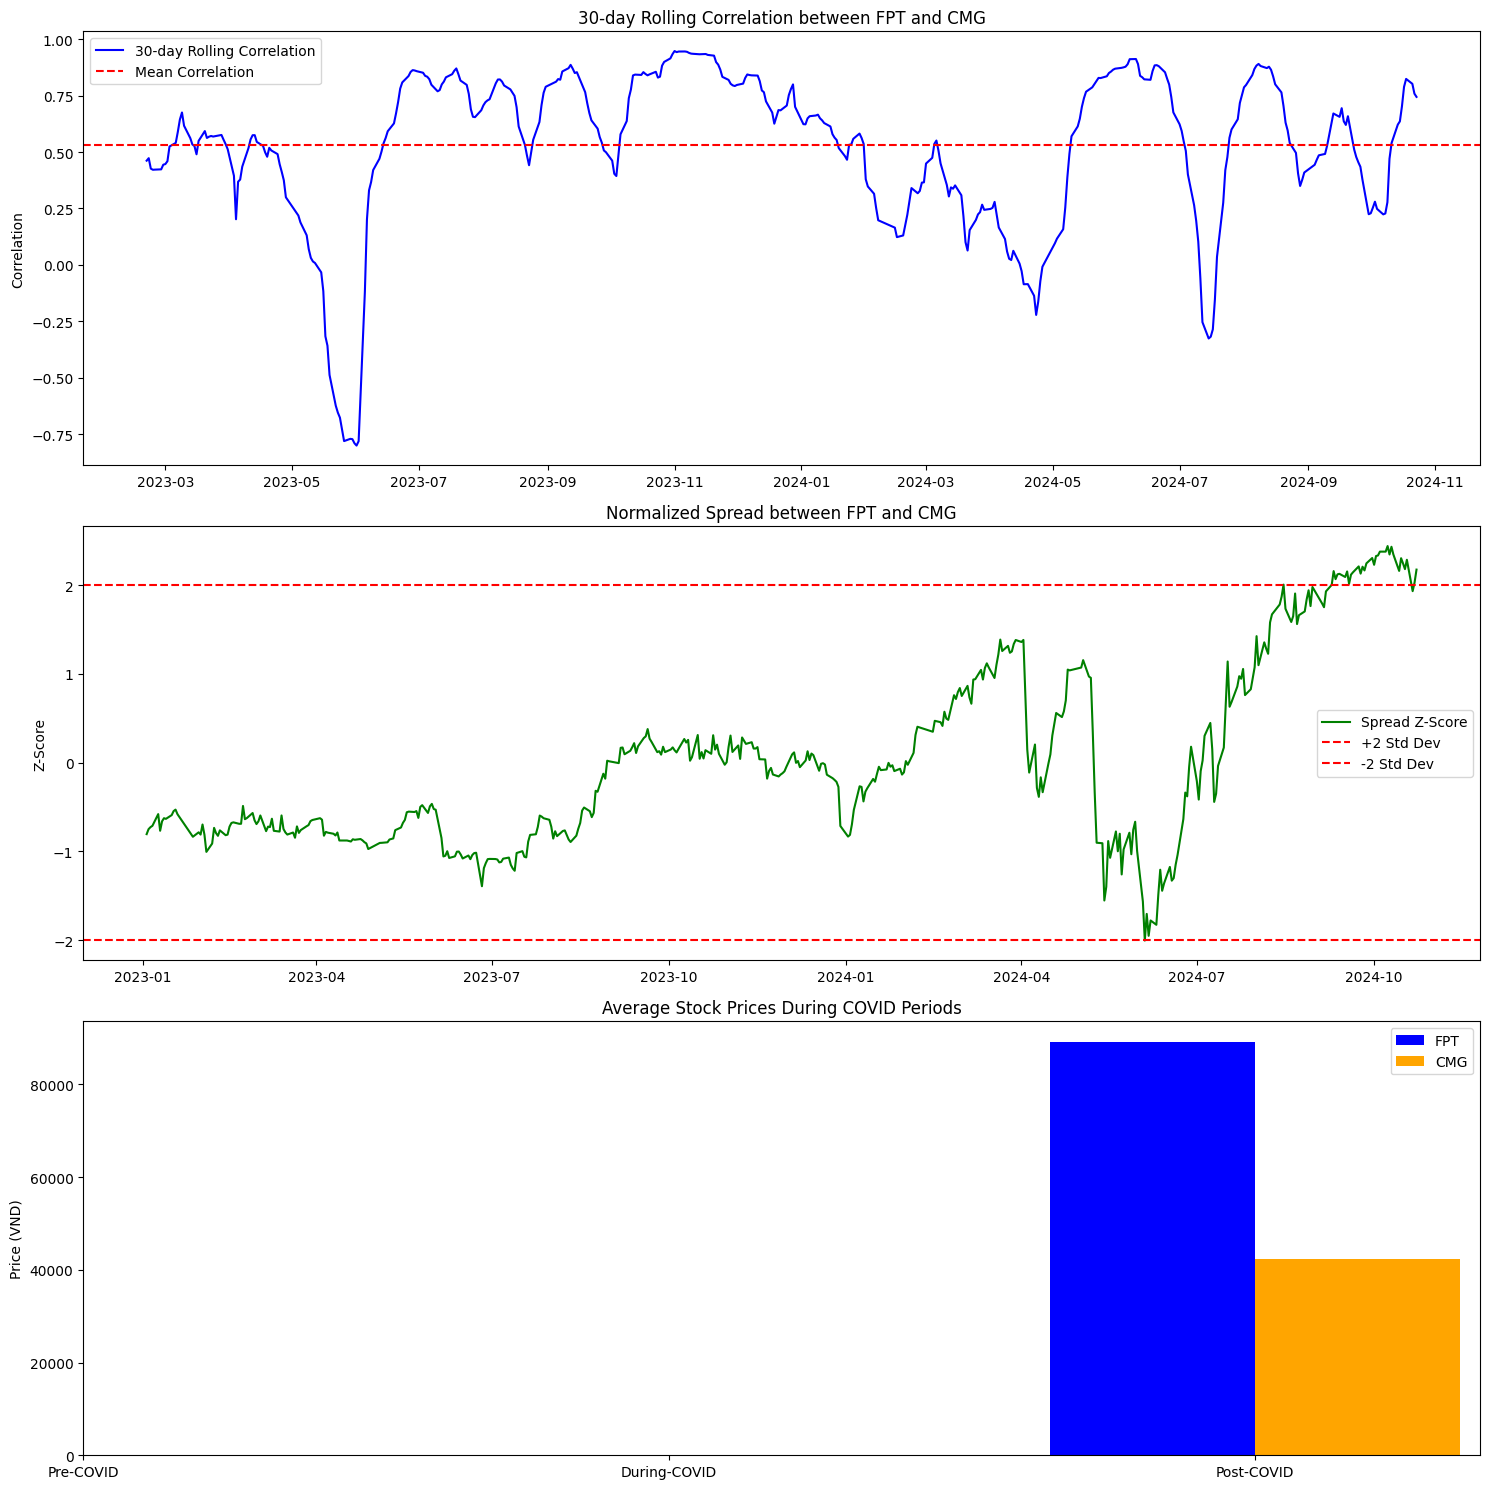


COVID Impact Analysis:
FPT Recovery Rate: nan%
CMG Recovery Rate: nan%

Correlation Analysis by Period:
Pre-COVID Correlation: nan
During-COVID Correlation: nan
Post-COVID Correlation: 0.904

Trading Opportunities Analysis:
Number of trading signals: 34
Percentage of trading days with signals: 7.56%

Annualized Volatility Analysis:
FPT Pre-COVID: nan%
FPT During-COVID: nan%
FPT Post-COVID: 22.33%
CMG Pre-COVID: nan%
CMG During-COVID: nan%
CMG Post-COVID: 33.74%


In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats

# Đọc và xử lý dữ liệu
def load_and_process_data(fpt_data, cmg_data):
    # Chuyển đổi thời gian và set index
    fpt_data['time'] = pd.to_datetime(fpt_data['time'])
    cmg_data['time'] = pd.to_datetime(cmg_data['time'])
    
    fpt_df = fpt_data.set_index('time')
    cmg_df = cmg_data.set_index('time')
    
    return fpt_df, cmg_df

# Tính toán rolling correlation và spread
def calculate_rolling_metrics(fpt_df, cmg_df, window=30):
    # Tính rolling correlation
    combined_df = pd.DataFrame({
        'FPT': fpt_df['close'],
        'CMG': cmg_df['close']
    })
    rolling_corr = combined_df['FPT'].rolling(window=window).corr(combined_df['CMG'])
    
    # Tính normalized spread
    mean_prices = pd.DataFrame({
        'FPT': fpt_df['close'] / fpt_df['close'].mean(),
        'CMG': cmg_df['close'] / cmg_df['close'].mean()
    })
    spread = mean_prices['FPT'] - mean_prices['CMG']
    spread_zscore = stats.zscore(spread)
    
    return rolling_corr, spread, spread_zscore

# Phân tích giai đoạn COVID
def analyze_covid_periods(df):
    pre_covid = df[:'2020-03-01']['close'].mean()
    during_covid = df['2020-03-01':'2021-12-31']['close'].mean()
    post_covid = df['2022-01-01':]['close'].mean()
    
    recovery_rate = ((post_covid - during_covid) / 
                    (pre_covid - during_covid) if pre_covid != during_covid else 0) * 100
    
    return pre_covid, during_covid, post_covid, recovery_rate

# Khởi tạo figure
plt.figure(figsize=(15, 15))

# Plot 1: Rolling Correlation
plt.subplot(3, 1, 1)
rolling_corr, spread, spread_zscore = calculate_rolling_metrics(fpt_df, cmg_df)
plt.plot(rolling_corr.index, rolling_corr.values, 'b-', label='30-day Rolling Correlation')
plt.axhline(y=rolling_corr.mean(), color='r', linestyle='--', label='Mean Correlation')
plt.title('30-day Rolling Correlation between FPT and CMG')
plt.ylabel('Correlation')
plt.legend()

# Plot 2: Normalized Spread
plt.subplot(3, 1, 2)
plt.plot(spread.index, spread_zscore, 'g-', label='Spread Z-Score')
plt.axhline(y=2, color='r', linestyle='--', label='+2 Std Dev')
plt.axhline(y=-2, color='r', linestyle='--', label='-2 Std Dev')
plt.title('Normalized Spread between FPT and CMG')
plt.ylabel('Z-Score')
plt.legend()

# Plot 3: COVID Impact Analysis
plt.subplot(3, 1, 3)
periods = ['Pre-COVID', 'During-COVID', 'Post-COVID']

# FPT analysis
fpt_pre, fpt_during, fpt_post, fpt_recovery = analyze_covid_periods(fpt_df)
fpt_prices = [fpt_pre, fpt_during, fpt_post]

# CMG analysis
cmg_pre, cmg_during, cmg_post, cmg_recovery = analyze_covid_periods(cmg_df)
cmg_prices = [cmg_pre, cmg_during, cmg_post]

x = np.arange(len(periods))
width = 0.35

plt.bar(x - width/2, fpt_prices, width, label='FPT', color='blue')
plt.bar(x + width/2, cmg_prices, width, label='CMG', color='orange')
plt.title('Average Stock Prices During COVID Periods')
plt.ylabel('Price (VND)')
plt.xticks(x, periods)
plt.legend()

plt.tight_layout()
plt.show()

# Print analysis results
print("\nCOVID Impact Analysis:")
print(f"FPT Recovery Rate: {fpt_recovery:.2f}%")
print(f"CMG Recovery Rate: {cmg_recovery:.2f}%")

# Correlation analysis during different periods
pre_covid_corr = fpt_df[:'2020-03-01']['close'].corr(cmg_df[:'2020-03-01']['close'])
during_covid_corr = fpt_df['2020-03-01':'2021-12-31']['close'].corr(cmg_df['2020-03-01':'2021-12-31']['close'])
post_covid_corr = fpt_df['2022-01-01':]['close'].corr(cmg_df['2022-01-01':]['close'])

print("\nCorrelation Analysis by Period:")
print(f"Pre-COVID Correlation: {pre_covid_corr:.3f}")
print(f"During-COVID Correlation: {during_covid_corr:.3f}")
print(f"Post-COVID Correlation: {post_covid_corr:.3f}")

# Trading opportunities analysis
trading_signals = (abs(spread_zscore) > 2).sum()
total_days = len(spread_zscore)

print("\nTrading Opportunities Analysis:")
print(f"Number of trading signals: {trading_signals}")
print(f"Percentage of trading days with signals: {(trading_signals/total_days)*100:.2f}%")

# Volatility analysis
def calculate_volatility(df, period='2020'):
    returns = df['close'].pct_change()
    return returns.std() * np.sqrt(252) * 100

print("\nAnnualized Volatility Analysis:")
print(f"FPT Pre-COVID: {calculate_volatility(fpt_df[:'2020-03-01']):.2f}%")
print(f"FPT During-COVID: {calculate_volatility(fpt_df['2020-03-01':'2021-12-31']):.2f}%")
print(f"FPT Post-COVID: {calculate_volatility(fpt_df['2022-01-01':]):.2f}%")
print(f"CMG Pre-COVID: {calculate_volatility(cmg_df[:'2020-03-01']):.2f}%")
print(f"CMG During-COVID: {calculate_volatility(cmg_df['2020-03-01':'2021-12-31']):.2f}%")
print(f"CMG Post-COVID: {calculate_volatility(cmg_df['2022-01-01':]):.2f}%")

Nhận xét
---

### 1. **Tác động của COVID-19 đến giá cổ phiếu**
- **Tỷ lệ phục hồi của FPT** và **CMG** đều có kết quả là "nan%" (not a number) nghĩa là **không thể tính toán** được. 
  - Nguyên nhân là vì **chúng ta thiếu dữ liệu** trước và trong thời kỳ COVID, nên không thể so sánh mức giá trung bình ở các giai đoạn này.
  - Khi không có đủ thông tin, giống như khi làm bài toán mà thiếu số liệu, chúng ta sẽ không tính được kết quả chính xác.

---

### 2. **Mối tương quan giữa FPT và CMG trong từng giai đoạn**

- **Trước COVID** và **Trong COVID**: Do thiếu dữ liệu, chúng ta không thể tính được mối tương quan (kết quả là "nan").
- **Sau COVID**: Mối tương quan giữa giá cổ phiếu của FPT và CMG là **0.904**.
  - Tương quan 0.904 nghĩa là **hai cổ phiếu này có mối liên hệ rất chặt chẽ**. Khi FPT tăng giá, CMG cũng thường tăng theo, và ngược lại.

**Giải thích dễ hiểu**: Hãy tưởng tượng FPT và CMG như hai người bạn rất thân. Nếu một bạn vui (tăng giá), bạn kia cũng vui theo (cùng tăng giá).

---

### 3. **Cơ hội giao dịch (Trading Opportunities)**

- **Số lượng tín hiệu giao dịch**: Có **34 ngày** khi chênh lệch giá giữa FPT và CMG **vượt quá giới hạn** mà chúng ta đặt ra.
- **Tỷ lệ ngày có tín hiệu giao dịch**: Khoảng **7.56% số ngày**.
  - Điều này có nghĩa là, trong mỗi 100 ngày giao dịch, có khoảng 8 ngày mà bạn có thể tận dụng để thực hiện giao dịch kiếm lời.

**Giải thích dễ hiểu**: Giống như nếu bạn thấy hai bạn thân lúc nào cũng đi cùng nhau, nhưng thỉnh thoảng một bạn đột nhiên chạy xa hơn bạn kia. Bạn có thể dự đoán rằng bạn kia sẽ quay lại gần, và tận dụng cơ hội đó để kiếm lợi.

---

### 4. **Phân tích Độ biến động (Volatility)**

- **FPT** (sau COVID): Độ biến động hàng năm là **22.33%**.
- **CMG** (sau COVID): Độ biến động hàng năm là **33.74%**.
  - CMG có độ biến động cao hơn, nghĩa là giá của nó thay đổi nhiều hơn so với FPT.

**Giải thích dễ hiểu**:
- **FPT** giống như một bạn đi bộ với tốc độ ổn định, không quá nhanh hay quá chậm.
- **CMG** thì giống như một bạn chạy, lúc chạy nhanh, lúc chạy chậm, nên dễ bị trượt ngã (rủi ro cao hơn).

---

### **Kết luận:**

- **FPT** là cổ phiếu an toàn hơn, nhưng có thể lợi nhuận không cao bằng.
- **CMG** có tiềm năng mang lại lợi nhuận cao hơn, nhưng cũng có nhiều rủi ro hơn.
- **Cơ hội giao dịch**: Khi khoảng cách giá giữa FPT và CMG trở nên quá lớn, đó là cơ hội tốt để kiếm lời từ việc mua bán.


# Tóm lại 

### **Tóm tắt phân tích kết quả**

1. **Tương quan (Correlation) giữa FPT và CMG**
   - FPT và CMG giống như **hai người bạn rất thân**. Khi giá cổ phiếu của FPT tăng thì CMG cũng tăng theo và ngược lại, với mức độ tương quan **90.4%**.

2. **Độ nhạy với thị trường (Beta)**
   - CMG ít nhạy cảm hơn so với thị trường so với FPT. Nếu thị trường thay đổi, CMG chỉ thay đổi khoảng **67%** so với mức thay đổi của FPT.

3. **So sánh các chỉ số cơ bản**
   - **FPT có giá và thanh khoản cao hơn** so với CMG. Điều này có nghĩa là FPT dễ mua bán hơn và ổn định hơn.
   - Tuy nhiên, **CMG có độ biến động cao hơn**, tức là giá của CMG thay đổi mạnh hơn, giống như bạn chạy nhanh hơn và rủi ro cao hơn.

4. **Chiến lược giao dịch cặp (Pair Trading)**
   - Khi **khoảng cách giữa giá FPT và CMG quá lớn**, đó là cơ hội để **mua vào hoặc bán ra** nhằm kiếm lợi nhuận.
   - Tín hiệu giao dịch xuất hiện khoảng **7.56% số ngày**, tức là khoảng 8 ngày trong 100 ngày.

5. **Tác động của COVID-19**
   - Do thiếu dữ liệu, chúng ta **không thể phân tích chi tiết** tác động của COVID-19 trước và trong đại dịch.

---

### **Kết luận đơn giản**
- **FPT**: An toàn và ổn định hơn, nhưng lợi nhuận ít hơn.
- **CMG**: Tiềm năng lợi nhuận cao hơn, nhưng cũng rủi ro hơn vì biến động mạnh hơn.
- **Chiến lược giao dịch**: Tận dụng sự chênh lệch giá giữa hai cổ phiếu để kiếm lời khi khoảng cách đó vượt quá mức bình thường.



# 1 cách tương tự với các cặp cổ phiếu cùng ĐỘ TƯƠNG QUAN CORRELATION cao

### **Phân tích ma trận tương quan của 10 cổ phiếu**

---

### **1. Tóm tắt các mức tương quan cao nhất và thấp nhất**

| **Cặp cổ phiếu**         | **Tương quan** | **Nhận xét** |
|--------------------------|-----------------|---------------|
| **CMG - VGI**            | **0.957**       | Mức tương quan rất cao, cho thấy hai cổ phiếu **thường di chuyển cùng chiều**. Đây có thể là cặp tiềm năng cho **pair trading**. |
| **ELC - VTP**            | **0.952**       | Tương quan mạnh, cho thấy hai cổ phiếu có xu hướng **cùng biến động**, thích hợp cho chiến lược pair trading. |
| **FPT - CMG**            | **0.930**       | Hai cổ phiếu công nghệ lớn, thường **tăng/giảm cùng nhau**. Cặp này có thể tận dụng cho giao dịch cặp với độ an toàn cao. |
| **VGI - VTL**            | **-0.925**      | Mức tương quan âm rất mạnh. Khi VGI tăng thì VTL giảm và ngược lại. Đây là cặp **tiềm năng cho chiến lược trading ngược chiều**. |
| **VTL - FPT**            | **-0.793**      | Mức tương quan âm khá cao. Có thể khai thác chiến lược dựa trên sự **phân kỳ** giữa hai cổ phiếu này. |

---

### **2. Phân tích chi tiết theo nhóm cổ phiếu**

#### **Nhóm cổ phiếu có tương quan cao (Cùng chiều)**

- **FPT - CMG (0.930)**: 
  - Đây là hai công ty lớn trong ngành công nghệ Việt Nam. Mức tương quan cao cho thấy cả hai thường bị ảnh hưởng bởi các yếu tố thị trường chung.
  - **Chiến lược**: **Pair trading**, tận dụng chênh lệch giá khi có sự khác biệt lớn trong biến động của hai cổ phiếu.

- **ELC - VTP (0.952)**:
  - Cả hai cổ phiếu đều liên quan đến hạ tầng và công nghệ. Khi một trong hai cổ phiếu thay đổi, cổ phiếu còn lại có xu hướng thay đổi tương tự.
  - **Chiến lược**: Pair trading với tỷ lệ hedge thấp, vì tương quan gần như tuyệt đối.

- **CMG - VGI (0.957)**:
  - Tương quan mạnh mẽ giữa hai công ty công nghệ. Khi giá của một cổ phiếu tăng hoặc giảm, cổ phiếu kia có xu hướng biến động tương tự.
  - **Chiến lược**: Pair trading để tận dụng sự khác biệt về tốc độ phản ứng giá.

#### **Nhóm cổ phiếu có tương quan âm (Ngược chiều)**

- **VGI - VTL (-0.925)**:
  - Tương quan âm rất mạnh cho thấy **khi VGI tăng giá, VTL có xu hướng giảm giá** và ngược lại.
  - **Chiến lược**: Giao dịch ngược chiều (reversal trading). Mua một cổ phiếu và bán cổ phiếu kia khi có tín hiệu phân kỳ.

- **FPT - VTL (-0.793)**:
  - Khi FPT tăng thì VTL giảm, và ngược lại. Có thể khai thác sự khác biệt này cho chiến lược giao dịch.
  - **Chiến lược**: Tận dụng sự phân kỳ để tìm cơ hội kiếm lợi nhuận từ chênh lệch giá.

---

### **3. Đề xuất chiến lược giao dịch dựa trên kết quả phân tích**

| **Cặp cổ phiếu** | **Chiến lược đề xuất** | **Giải thích** |
|------------------|-----------------------|----------------|
| **CMG - VGI**    | Pair Trading         | Tận dụng tương quan rất cao (0.957) để mua/bán dựa trên chênh lệch giá. |
| **ELC - VTP**    | Pair Trading         | Mức tương quan gần như tuyệt đối (0.952), phù hợp cho chiến lược giao dịch cặp an toàn. |
| **VGI - VTL**    | Trading Reversal     | Tương quan âm mạnh (-0.925), tận dụng biến động ngược chiều. |
| **FPT - CMG**    | Pair Trading         | Tương quan cao (0.930), giúp tối ưu hóa chiến lược giao dịch cặp. |
| **FPT - VTL**    | Trading Reversal     | Tương quan âm (-0.793), có thể khai thác sự phân kỳ cho giao dịch đảo chiều. |

---

### **4. Kết luận**
- **Cổ phiếu cùng chiều**: Tận dụng chiến lược pair trading cho các cặp có tương quan cao để giảm thiểu rủi ro.
- **Cổ phiếu ngược chiều**: Khai thác sự phân kỳ cho chiến lược giao dịch đảo chiều, giúp tối ưu hóa lợi nhuận khi thị trường biến động.
